In [1]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as Data
from tqdm import tqdm

import numpy as np
import copy
import json

USE_CUDA = True

In [2]:
def readfile(data):
    with open(data, "r", encoding="utf-8") as f:
        content = f.read().splitlines()
        
    return content

def schema_load(schema_root):
    raw_dict = "".join(readfile(schema_root))
    dict2json = "".join(raw_dict.split()[2:])

    json_acceptable_string = dict2json.replace("'", "\"")
    schema = json.loads(json_acceptable_string)
    
    return schema

def define_entity(schema):
    tag_type = list(schema['tagging'])
    
    entity_tag = []
    for k in list(schema['entity'].keys()):
        entity_tag.append(schema['entity'][k]['tag'])
        
    TAG = []
    for t in tag_type:
        for e in entity_tag:
            if t!='O':
                TAG.append(t+'-'+e)  
                
    TAG = [UNKOWN_TAG, PAD_TAG] + TAG + ['O']   

    return TAG

def tag2ix(TAG):
    tag_to_ix={t:i for i,t in enumerate(TAG)}
    return tag_to_ix

def define_relation(schema):
    relation_type = list(schema['relation'])
    
    relation_tag = []
    for k in list(schema['relation'].keys()):
        relation_tag.append(schema['relation'][k]['tag'])
    
    relation_tag = [REL_PAD] + [REL_NONE] + relation_tag
        
    return relation_tag

# ==================================================

def get_word_and_label(_content, start_w, end_w):
    word_list = []
    ent_list = []
    rel_list = []
    
    for word_set in _content[start_w:end_w]:
        word_set = word_set.split()
        if len(word_set)==1:
            word_list.append(' ')
            ent_list.append('O')
            rel_list.append(REL_NONE)
        
        else:
            word_list.append(word_set[0])
            ent_list.append(word_set[1])

            try:
                testerror = word_set[2]
            except IndexError:
                rel_list.append(REL_NONE)
            else:
                rel_list.append(word_set[2:])
    
    return word_list, ent_list, rel_list

def split_to_list(content):
    init = 0
    word_list = []
    ent_list = []
    rel_list = []

    for now_token, c in enumerate(content):
        if c=='':
            words, ents, rels = get_word_and_label(content, init, now_token)
            init = now_token+1
            word_list.append(words)
            ent_list.append(ents)
            rel_list.append(rels)
            
    return word_list, ent_list, rel_list

# ==================================================

def word2index(word_list):
    word_to_ix = {"<UNKNOWN>":0, "<PAD>":1}
    for sentence in word_list:
        for word in sentence:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
                
    return word_to_ix

def dict_inverse(tag_to_ix):
    ix_to_tag = {v: k for k, v in tag_to_ix.items()}
    return ix_to_tag

def index2tag(indexs, ix_to):
    to_tags = [ix_to[i] for i in indexs.cpu().numpy()]
    return to_tags

# ==================================================

def find_max_len(word_list):
    max_len = 0
    for i in range(len(word_list)):
        if max_len<len(word_list[i]):
            max_len=len(word_list[i])
            
    return max_len

# ====== filter the length of sentence more than MAX_LEN =======

def filter_len(word_list):
    reserved_index = []
    for i in range(len(word_list)):
        if len(word_list[i])<MAX_LEN:
            reserved_index.append(i)
            
    return reserved_index


def filter_sentence(reserved_index, word_list, ent_list, rel_list):
    filter_word = list(word_list[i] for i in reserved_index)
    filter_ent = list(ent_list[i] for i in reserved_index)
    filter_rel = list(rel_list[i] for i in reserved_index)
    return filter_word, filter_ent, filter_rel

# ==================================================

def pad_seq(seq, isrel):
    if isrel:
        seq += [REL_NONE for i in range(MAX_LEN-len(seq))]
    else:
        seq += [PAD_TAG for i in range(MAX_LEN-len(seq))]
    return seq

def pad_all(filter_word, filter_ent, filter_rel):
    input_padded = [pad_seq(s, False) for s in filter_word]
    ent_padded = [pad_seq(s, False) for s in filter_ent]
    rel_padded = [pad_seq(s, True) for s in filter_rel]
    
    return input_padded, ent_padded, rel_padded

def deep_copy_lists(filter_word, filter_ent, filter_rel):
    f_w = copy.deepcopy(filter_word)
    f_e = copy.deepcopy(filter_ent)
    f_r = copy.deepcopy(filter_rel)
    
    return f_w, f_e, f_r

# ==================================================

def prepare_sequence(seq, to_ix):
    idxs = []
    for w in seq:
        if w not in to_ix:
            idxs.append(to_ix[UNKOWN_TAG])
        else:
            idxs.append(to_ix[w])
    
#     idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)

def prepare_all(seqs, to_ix):
    seq_list = []
    for i in range(len(seqs)):
        seq_list.append(prepare_sequence(seqs[i], to_ix))
        
    seq_list = torch.stack(seq_list)
        
    return seq_list



def prepare_rel(rel_padded, to_ix):
    
    rel_ptr = torch.zeros(len(rel_padded), MAX_LEN, MAX_LEN, dtype=torch.long) 
    
    # 對當前的token，去比較之前所有出現過的entity，是否有關係，建成矩陣
    # [B*ML*ML]，第二維ML是當前token，第三維ML是根據當前token對之前出現過的entity紀錄關係，以index紀錄
    for i, rel_seq in enumerate(rel_padded):
        rel_dict = {}
        for j, token_seq in enumerate(rel_seq):
            rel_ptr[i][j][:j+1] = 1
            if token_seq != REL_NONE:
                for k, rel in enumerate(token_seq):

                    # if 是第一次出現，紀錄後面數字(標第幾對)和關係位置(A OR B)
                    # 假如下次出現又是同個關係位置(A)，依然紀錄
                    # 直到下次出現關係位置B，依照之前紀錄的A位置的字，然後在第三維去標關係

                    rel_token = rel.split('-')
                    if rel_token[1] not in rel_dict:
                        rel_dict[rel_token[1]] = {'rel':rel_token[0], 'loc':rel_token[2], 'idx':[j]}

                    elif rel_token[1] in rel_dict and rel_dict[rel_token[1]]['loc']==rel_token[2]:
                        rel_dict[rel_token[1]]['idx'].append(j)

                    else:
                        record_loc = rel_dict[rel_token[1]]['idx']
                        for idxx in record_loc:
                            rel_ptr[i][j][idxx] = to_ix[rel_token[0]]
                            
    return rel_ptr
                


# ==================================================

def dataload(input_var, ent_var, rel_var, raw_input):
    torch_dataset = Data.TensorDataset(input_var, ent_var, rel_var, raw_input)

    loader = Data.DataLoader(
        dataset=torch_dataset,      # torch TensorDataset format
        batch_size=BATCH_SIZE,      # mini batch size
        shuffle=True,               
        num_workers=0,       
#         drop_last=True
    )
    
    return loader

# ==================================================
def softmax_entity(entity):
    entity = entity.view(BATCH_SIZE,ent_size).argmax(1)
    return entity

In [3]:
class Attn(nn.Module):
    def __init__(self, attn_input, attn_output, rel_size):
        super(Attn, self).__init__()
        
        self.attn_input = attn_input
        self.attn_output = attn_output
        self.rel_size = rel_size
        
        self.w1 = nn.Linear(self.attn_input, self.attn_output)
        self.w2 = nn.Linear(self.attn_input, self.attn_output)
        self.tanh = nn.Tanh()
        self.v = nn.Linear(self.attn_output, self.rel_size, bias=False)
        self.softmax = nn.LogSoftmax(dim=2)
        
        
    def forward(self, encoder_outputs):
        
        decoder = encoder_outputs[:,-1,:].unsqueeze(1)                       #B*1*(ts+LE) [128,1,8]
        encoder_score = self.w1(encoder_outputs)                             #B*now len*ATTN_OUT
        decoder_score = self.w2(decoder)                                     #B*1*ATTN_OUT
        energy = self.tanh(encoder_score+decoder_score)                      #B*now len*ATTN_OUT            
        
        energy = self.v(energy)                                              #B*now len*rel_size
        
        
        # 針對每個entity做softmax，去顯示他們的關係權重
        # 主要都會是rel_none
        # 對第二維(rel)做softmax
        p = self.softmax(energy)                                         #B*now len*rel_size
        
        return p
    

In [4]:
class Entity_Typing(nn.Module):
    def __init__(self, vocab_size, ent_tag_to_ix, embedding_dim, hidden_dim1, hidden_dim2, \
                 label_embed_dim, rel_tag_to_ix):
        
        super(Entity_Typing, self).__init__()
        self.embedding_dim = embedding_dim                   #E
        self.hidden_dim1 = hidden_dim1                       #h1
        self.hidden_dim2 = hidden_dim2                       #h2
        self.label_embed_dim = label_embed_dim               #LE
        self.vocab_size = vocab_size                         #vs
        self.ent_to_ix = ent_tag_to_ix
        self.ent_size = len(ent_tag_to_ix)                   #es
        self.rel_to_ix = rel_tag_to_ix
        self.rel_size = len(rel_tag_to_ix)                   #rs           
        
        self.dropout = nn.Dropout(p=0.3)
        self.bn = nn.BatchNorm1d(hidden_dim1, momentum=0.5, affine=False)
        
        
        self.word_embeds = nn.Embedding(vocab_size, embedding_dim)
        
#         self.bilstm = nn.LSTM(embedding_dim, hidden_dim1 // 2,
#                             num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)        
        self.bilstm = nn.GRU(embedding_dim, hidden_dim1 // 2,
                            num_layers=2, bidirectional=True, batch_first=True, dropout=0.2)
        
        
        self.dense = nn.Linear(hidden_dim1, DENSE_OUT)
        self.top_hidden = nn.LSTMCell(DENSE_OUT+label_embed_dim, hidden_dim2)          
        

        # Maps the output of the LSTM into tag space.
        self.hidden2tag = nn.Linear(hidden_dim2, self.ent_size)
        self.softmax = nn.LogSoftmax(dim=1)
        self.label_embed = nn.Linear(self.ent_size, self.label_embed_dim)
        
        self.attn = Attn(ATTN_IN, ATTN_OUT, self.rel_size)
        
        
    def init_hidden1(self):       
        hidden = torch.randn(2*2, self.batch, self.hidden_dim1 // 2)    #4*B*(h1/2)

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_hidden2(self):       
        hidden = torch.randn(self.batch, self.hidden_dim2)              #B*h2

        return (hidden.cuda(), hidden.cuda())if USE_CUDA else (hidden,hidden)
    
    def init_label_embed(self):
        hidden = torch.zeros(self.batch, self.label_embed_dim)          #B*LE
        return hidden.cuda()if USE_CUDA else hidden
    
    def create_entity(self):
        output_tensor = torch.zeros(self.batch, MAX_LEN, self.ent_size)  #B*ML*es
        return output_tensor.cuda()if USE_CUDA else output_tensor
    
    def create_rel_matrix(self):
        rel_tensor = torch.zeros(self.batch, MAX_LEN, MAX_LEN, self.rel_size)  #B*ML*ML*rs
        return rel_tensor.cuda()if USE_CUDA else rel_tensor
    
    
        
    def forward(self, sentence, batch_ent, isTrain=True):
        
        self.batch = sentence.size(0)
#         self.hidden1 = self.init_hidden1()                      #4*B*(h1/2)
        entity_tensor = self.create_entity()                    #B*ML*es
        rel_tensor = self.create_rel_matrix()                   #B*ML*ML*rs
        
        

        embeds = self.word_embeds(sentence)                     #B*ML*E,[128, 100, 20]
        
#         bilstm_out, self.hidden1 = self.bilstm(embeds, self.hidden1)
        bilstm_out, hidden1 = self.bilstm(embeds)
        # bilstm_out -> B*ML*h1,[128, 100, 10]
        # self.hidden1 -> ( 4*B*(h1/2), 4*B*(h1/2) )
        
        bilstm_out = torch.transpose(bilstm_out, 1, 2)
        # bn
        bilstm_out = self.bn(bilstm_out)
        bilstm_out = torch.transpose(bilstm_out, 1, 2)
        dense_out = self.dense(bilstm_out)                      #B*ML*DENSE_OUT,[128, 100, 100]
        
        
        encoder_sequence_l = [] 

        for length in range(MAX_LEN):
            now_token = dense_out[:,length,:]
            now_token = torch.squeeze(now_token, 1)
            
            if length==0:
                self.hidden2 = self.init_hidden2()
                self.zero_label_embed = self.init_label_embed()
                combine_x = torch.cat((now_token, self.zero_label_embed),1)  #B*(DENSE_OUT+LE),[128, 103]
                
            else:
                self.hidden2 = (h_next, c_next)
                combine_x = torch.cat((now_token, label),1)

            h_next, c_next = self.top_hidden(combine_x, self.hidden2)    #B*h2,[128, 8]           
            to_tags = self.hidden2tag(h_next)                            #B*es,[128, 5]            
            ent_output = self.softmax(to_tags)                               #B*es,[128, 5]  
            s_ent_output = self.softmax_entity(ent_output)
            ent_onehot = self.one_hot(s_ent_output)
            
            
            if isTrain:
                label = self.label_embed(ent_onehot)                             #B*LE,[128, 3]
#                 label = self.label_embed(ent_output) 
            else:
                batch_ent_onehot = self.one_hot(batch_ent[:,length])
                label = self.label_embed(batch_ent_onehot)
            
     
            
            # Assignments to Variables are in-place operations.
            # Use that variable in lots of other contexts 
            # and some of the functions require it to not change. 
            to_tags_clone = to_tags.clone()
            label_clone = label.clone()
            
            
#             for i, tag in enumerate(s_ent_output):
#                 if tag==ent_tag_to_ix['O']:
#                     to_tags_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
#                     label_clone[i] = torch.FloatTensor([-999999 * self.ent_size])
                    
            # relation layer
#             encoder_sequence_l.append(torch.cat((to_tags,label),1)) 
            encoder_sequence_l.append(torch.cat((h_next,label),1))  
            encoder_sequence = torch.stack(encoder_sequence_l).t()     #B*len*(es+LE), [128,1,8]          

            # Calculate attention weights 
            attn_weights = self.attn(encoder_sequence)

        
            entity_tensor[:,length,:] = ent_output
            
            # rel_tensor[:,length, 頭~當前 ,:]
            rel_tensor[:,length,:length+1,:] = attn_weights

        
        
        '''NLLLoss input: Input: (N,C) where C = number of classes'''
        return entity_tensor.view(self.batch*MAX_LEN, self.ent_size), \
               rel_tensor.view(self.batch*MAX_LEN*MAX_LEN, self.rel_size)
        
        
    def softmax_entity(self, entity):
        entity = entity.view(self.batch,ent_size).argmax(1)
        return entity
    
    
    def one_hot(self, batch_ent):   
        batchsize = batch_ent.size(0)
        nb_digits = len(ent_tag_to_ix)
        batch_ent = torch.unsqueeze(batch_ent, 1)
        y_onehot = torch.cuda.FloatTensor(batchsize, nb_digits)        
        y_onehot.zero_()
        y_onehot.scatter_(1, batch_ent, 1)    

        return y_onehot

In [5]:
root = '/notebooks/sinica/dataset/'
train_data = root+'facial.train'
dev_data = root+'facial.dev'
test_data = root+'facial.test'

relation_data_old = root+'facial_r.old.train'
# relation_data = root+'facial_r.train'
relation_data = root+'facial_r2.train'
schema_root = root+'schema_2.txt'
dev_data = root+'facial_r2.dev'
test_data = root+'facial_r2.test'


UNKOWN_TAG = "<UNKNOWN>"
PAD_TAG = "<PAD>"
REL_NONE = 'Rel-None'
REL_PAD = 'Rel-Pad'
rule = ('FUNC', 'ApplyTo', 'STAT')

schema = schema_load(schema_root)
ENT_TAG = define_entity(schema)
REL_TAG = define_relation(schema)
ent_tag_to_ix = tag2ix(ENT_TAG)
'''{'<PAD>': 1,
 '<UNKNOWN>': 0,
 'B-FUNC': 2,
 'B-STAT': 3,
 'I-FUNC': 4,
 'I-STAT': 5,
 'O': 6}'''
rel_tag_to_ix = tag2ix(REL_TAG)
'''{'ApplyTo': 2, 'Rel-None': 1, 'Rel-Pad': 0}'''

# ========hyper-parameter-set==========

ent_size = len(ent_tag_to_ix)
rel_size = len(rel_tag_to_ix)
MAX_LEN = 70     # original 100
BATCH_SIZE = 16

EMBEDDING_DIM = 40
HIDDEN_DIM1 = 20
HIDDEN_DIM2 = 16
LABEL_EMBED_DIM = ent_size
DENSE_OUT = 100

# ATTN_IN = ent_size+LABEL_EMBED_DIM
ATTN_IN = HIDDEN_DIM2+LABEL_EMBED_DIM
ATTN_OUT = 6

In [6]:
def preprocess(data):
    content = readfile(data)
    word_list, ent_list, rel_list = split_to_list(content)
    word_to_ix = word2index(word_list)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    #================================================
    vocab_size = len(word_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, vocab_size, word_to_ix, reserved_index, word_list

def dev_preprocess(dev_data):
    dev_content = readfile(dev_data)
    word_list, ent_list, rel_list = split_to_list(dev_content)
    reserved_index = filter_len(word_list)
    filter_word, filter_ent, filter_rel = filter_sentence(reserved_index, word_list, ent_list, rel_list)
    f_w, f_e, f_r = deep_copy_lists(filter_word, filter_ent, filter_rel)
    input_padded, ent_padded, rel_padded = pad_all(f_w, f_e, f_r)
    #================================================
    input_var = prepare_all(input_padded, word_to_ix)
    ent_var = prepare_all(ent_padded, ent_tag_to_ix)
    rel_var = prepare_rel(rel_padded, rel_tag_to_ix)
    
    reserved_index = torch.from_numpy(np.asarray(reserved_index))
    
    return input_var, ent_var, rel_var, reserved_index, word_list


In [7]:
ix_to_ent_tag = dict_inverse(ent_tag_to_ix)
ix_to_rel_tag = dict_inverse(rel_tag_to_ix)
#===============================================
input_var, ent_var, rel_var, vocab_size, word_to_ix, raw_index, raw_input = preprocess(relation_data)
loader = dataload(input_var, ent_var, rel_var, raw_index)

input_dev, ent_dev, rel_dev, raw_index_dev, raw_input_dev = dev_preprocess(dev_data)
dev_loader = dataload(input_dev, ent_dev, rel_dev, raw_index_dev)

In [8]:
model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
              LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion_tag = nn.NLLLoss(ignore_index=ent_tag_to_ix[PAD_TAG])
# criterion_rel = nn.NLLLoss(ignore_index=rel_tag_to_ix[REL_PAD])
criterion_rel = nn.NLLLoss()

In [9]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [10]:
n_iters = 100
print_every = 12

train_entloss_l = []
val_entloss_l = []
train_relloss_l = []
val_relloss_l = []

loss = 0
start = time.time()

for epoch in tqdm(range(n_iters)):  
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
        model.train()
        optimizer.zero_grad()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
        
        batchsize = batch_x.size(0)
        
        batch_ent = batch_ent.view(batchsize*MAX_LEN)
        batch_rel = batch_rel.view(batchsize*MAX_LEN*MAX_LEN)
        
        entloss = criterion_tag(ent_output, batch_ent.cuda() if USE_CUDA else batch_ent)
        relloss = criterion_rel(rel_output, batch_rel.cuda() if USE_CUDA else batch_rel)
        loss = entloss+relloss
        
        loss.backward()
#         loss.backward(retain_graph=True)
        optimizer.step()
        

    train_entloss_l.append(entloss.cpu())
    train_relloss_l.append(relloss.cpu())
    #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))
        
    for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
        model.eval()
        ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
        
        batchsize = batch_x.size(0)
        
        val_entloss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN)) 
        val_relloss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
        
    val_entloss_l.append(val_entloss.cpu())
    val_relloss_l.append(val_relloss.cpu())
    
    
    print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
          % (epoch+1, entloss, relloss, loss))
    print("      %s  | val ent loss %.4f | val rel loss %.4f"
          % (" "*len(str(epoch+1)), val_entloss, val_relloss))


  1%|          | 1/100 [00:03<05:57,  3.61s/it]

epoch: 1 | ent loss 0.6312 | rel loss 0.0579 | total loss 0.6891
         | val ent loss 0.4642 | val rel loss 0.0505


  2%|▏         | 2/100 [00:07<05:50,  3.58s/it]

epoch: 2 | ent loss 0.3630 | rel loss 0.0204 | total loss 0.3834
         | val ent loss 0.3365 | val rel loss 0.0188


  3%|▎         | 3/100 [00:10<05:51,  3.62s/it]

epoch: 3 | ent loss 0.3380 | rel loss 0.0140 | total loss 0.3520
         | val ent loss 0.3602 | val rel loss 0.0115


  4%|▍         | 4/100 [00:14<05:49,  3.64s/it]

epoch: 4 | ent loss 0.2704 | rel loss 0.0145 | total loss 0.2850
         | val ent loss 0.3574 | val rel loss 0.0106


  5%|▌         | 5/100 [00:18<05:46,  3.65s/it]

epoch: 5 | ent loss 0.1705 | rel loss 0.0146 | total loss 0.1851
         | val ent loss 0.2224 | val rel loss 0.0121


  6%|▌         | 6/100 [00:22<05:44,  3.67s/it]

epoch: 6 | ent loss 0.1606 | rel loss 0.0102 | total loss 0.1708
         | val ent loss 0.1368 | val rel loss 0.0106


  7%|▋         | 7/100 [00:25<05:38,  3.64s/it]

epoch: 7 | ent loss 0.1007 | rel loss 0.0103 | total loss 0.1109
         | val ent loss 0.2133 | val rel loss 0.0082


  8%|▊         | 8/100 [00:29<05:34,  3.64s/it]

epoch: 8 | ent loss 0.0714 | rel loss 0.0088 | total loss 0.0802
         | val ent loss 0.2221 | val rel loss 0.0093


  9%|▉         | 9/100 [00:32<05:31,  3.64s/it]

epoch: 9 | ent loss 0.0509 | rel loss 0.0092 | total loss 0.0601
         | val ent loss 0.1246 | val rel loss 0.0084


 10%|█         | 10/100 [00:36<05:25,  3.61s/it]

epoch: 10 | ent loss 0.0346 | rel loss 0.0096 | total loss 0.0442
          | val ent loss 0.1245 | val rel loss 0.0091


 11%|█         | 11/100 [00:39<05:21,  3.61s/it]

epoch: 11 | ent loss 0.0566 | rel loss 0.0090 | total loss 0.0657
          | val ent loss 0.2009 | val rel loss 0.0067


 12%|█▏        | 12/100 [00:43<05:18,  3.62s/it]

epoch: 12 | ent loss 0.0764 | rel loss 0.0063 | total loss 0.0827
          | val ent loss 0.1622 | val rel loss 0.0092


 13%|█▎        | 13/100 [00:46<05:13,  3.60s/it]

epoch: 13 | ent loss 0.0253 | rel loss 0.0090 | total loss 0.0343
          | val ent loss 0.1383 | val rel loss 0.0065


 14%|█▍        | 14/100 [00:50<05:08,  3.59s/it]

epoch: 14 | ent loss 0.0226 | rel loss 0.0073 | total loss 0.0299
          | val ent loss 0.1249 | val rel loss 0.0053


 15%|█▌        | 15/100 [00:54<05:06,  3.60s/it]

epoch: 15 | ent loss 0.0359 | rel loss 0.0084 | total loss 0.0443
          | val ent loss 0.1822 | val rel loss 0.0070


 16%|█▌        | 16/100 [00:57<05:03,  3.61s/it]

epoch: 16 | ent loss 0.0261 | rel loss 0.0075 | total loss 0.0336
          | val ent loss 0.1682 | val rel loss 0.0053


 17%|█▋        | 17/100 [01:01<05:00,  3.62s/it]

epoch: 17 | ent loss 0.0379 | rel loss 0.0051 | total loss 0.0430
          | val ent loss 0.1555 | val rel loss 0.0079


 18%|█▊        | 18/100 [01:05<04:56,  3.62s/it]

epoch: 18 | ent loss 0.0091 | rel loss 0.0064 | total loss 0.0155
          | val ent loss 0.1717 | val rel loss 0.0064


 19%|█▉        | 19/100 [01:08<04:53,  3.63s/it]

epoch: 19 | ent loss 0.0067 | rel loss 0.0074 | total loss 0.0141
          | val ent loss 0.1348 | val rel loss 0.0066


 20%|██        | 20/100 [01:12<04:51,  3.64s/it]

epoch: 20 | ent loss 0.0065 | rel loss 0.0074 | total loss 0.0139
          | val ent loss 0.1192 | val rel loss 0.0049


 21%|██        | 21/100 [01:16<04:47,  3.64s/it]

epoch: 21 | ent loss 0.0068 | rel loss 0.0062 | total loss 0.0130
          | val ent loss 0.1862 | val rel loss 0.0044


 22%|██▏       | 22/100 [01:20<04:44,  3.64s/it]

epoch: 22 | ent loss 0.0080 | rel loss 0.0067 | total loss 0.0146
          | val ent loss 0.1231 | val rel loss 0.0046


 23%|██▎       | 23/100 [01:23<04:40,  3.64s/it]

epoch: 23 | ent loss 0.0202 | rel loss 0.0042 | total loss 0.0244
          | val ent loss 0.1653 | val rel loss 0.0022


 24%|██▍       | 24/100 [01:27<04:36,  3.64s/it]

epoch: 24 | ent loss 0.0170 | rel loss 0.0058 | total loss 0.0228
          | val ent loss 0.1851 | val rel loss 0.0071


 25%|██▌       | 25/100 [01:30<04:32,  3.64s/it]

epoch: 25 | ent loss 0.0389 | rel loss 0.0049 | total loss 0.0438
          | val ent loss 0.2099 | val rel loss 0.0025


 26%|██▌       | 26/100 [01:34<04:28,  3.63s/it]

epoch: 26 | ent loss 0.0279 | rel loss 0.0051 | total loss 0.0330
          | val ent loss 0.2933 | val rel loss 0.0049


 27%|██▋       | 27/100 [01:37<04:23,  3.61s/it]

epoch: 27 | ent loss 0.0151 | rel loss 0.0052 | total loss 0.0203
          | val ent loss 0.2011 | val rel loss 0.0041


 28%|██▊       | 28/100 [01:41<04:20,  3.61s/it]

epoch: 28 | ent loss 0.0369 | rel loss 0.0050 | total loss 0.0420
          | val ent loss 0.1944 | val rel loss 0.0022


 29%|██▉       | 29/100 [01:44<04:15,  3.60s/it]

epoch: 29 | ent loss 0.0057 | rel loss 0.0039 | total loss 0.0096
          | val ent loss 0.1172 | val rel loss 0.0033


 30%|███       | 30/100 [01:47<04:11,  3.59s/it]

epoch: 30 | ent loss 0.0064 | rel loss 0.0042 | total loss 0.0106
          | val ent loss 0.2399 | val rel loss 0.0025


 31%|███       | 31/100 [01:51<04:08,  3.60s/it]

epoch: 31 | ent loss 0.0060 | rel loss 0.0041 | total loss 0.0102
          | val ent loss 0.1906 | val rel loss 0.0025


 32%|███▏      | 32/100 [01:54<04:03,  3.58s/it]

epoch: 32 | ent loss 0.0050 | rel loss 0.0053 | total loss 0.0103
          | val ent loss 0.1530 | val rel loss 0.0040


 33%|███▎      | 33/100 [01:58<04:00,  3.59s/it]

epoch: 33 | ent loss 0.0037 | rel loss 0.0037 | total loss 0.0075
          | val ent loss 0.1771 | val rel loss 0.0022


 34%|███▍      | 34/100 [02:02<03:56,  3.59s/it]

epoch: 34 | ent loss 0.0064 | rel loss 0.0036 | total loss 0.0100
          | val ent loss 0.1223 | val rel loss 0.0029


 35%|███▌      | 35/100 [02:05<03:53,  3.59s/it]

epoch: 35 | ent loss 0.0025 | rel loss 0.0035 | total loss 0.0060
          | val ent loss 0.1631 | val rel loss 0.0034


 36%|███▌      | 36/100 [02:08<03:49,  3.58s/it]

epoch: 36 | ent loss 0.0036 | rel loss 0.0028 | total loss 0.0064
          | val ent loss 0.1388 | val rel loss 0.0022


 37%|███▋      | 37/100 [02:12<03:45,  3.58s/it]

epoch: 37 | ent loss 0.0040 | rel loss 0.0036 | total loss 0.0076
          | val ent loss 0.2504 | val rel loss 0.0021


 38%|███▊      | 38/100 [02:15<03:41,  3.58s/it]

epoch: 38 | ent loss 0.0025 | rel loss 0.0022 | total loss 0.0047
          | val ent loss 0.1141 | val rel loss 0.0024


 39%|███▉      | 39/100 [02:19<03:38,  3.57s/it]

epoch: 39 | ent loss 0.0018 | rel loss 0.0027 | total loss 0.0046
          | val ent loss 0.1290 | val rel loss 0.0019


 40%|████      | 40/100 [02:23<03:35,  3.59s/it]

epoch: 40 | ent loss 0.0041 | rel loss 0.0020 | total loss 0.0061
          | val ent loss 0.1321 | val rel loss 0.0019


 41%|████      | 41/100 [02:27<03:32,  3.60s/it]

epoch: 41 | ent loss 0.0039 | rel loss 0.0023 | total loss 0.0063
          | val ent loss 0.2607 | val rel loss 0.0019


 42%|████▏     | 42/100 [02:30<03:28,  3.59s/it]

epoch: 42 | ent loss 0.0054 | rel loss 0.0016 | total loss 0.0070
          | val ent loss 0.1409 | val rel loss 0.0017


 43%|████▎     | 43/100 [02:33<03:24,  3.58s/it]

epoch: 43 | ent loss 0.0036 | rel loss 0.0021 | total loss 0.0057
          | val ent loss 0.0799 | val rel loss 0.0017


 44%|████▍     | 44/100 [02:37<03:20,  3.57s/it]

epoch: 44 | ent loss 0.0042 | rel loss 0.0023 | total loss 0.0065
          | val ent loss 0.1286 | val rel loss 0.0019


 45%|████▌     | 45/100 [02:40<03:16,  3.57s/it]

epoch: 45 | ent loss 0.0089 | rel loss 0.0026 | total loss 0.0116
          | val ent loss 0.2000 | val rel loss 0.0018


 46%|████▌     | 46/100 [02:44<03:12,  3.57s/it]

epoch: 46 | ent loss 0.0014 | rel loss 0.0022 | total loss 0.0036
          | val ent loss 0.1895 | val rel loss 0.0014


 47%|████▋     | 47/100 [02:48<03:09,  3.58s/it]

epoch: 47 | ent loss 0.0042 | rel loss 0.0016 | total loss 0.0058
          | val ent loss 0.0671 | val rel loss 0.0018


 48%|████▊     | 48/100 [02:51<03:05,  3.57s/it]

epoch: 48 | ent loss 0.0049 | rel loss 0.0021 | total loss 0.0070
          | val ent loss 0.0095 | val rel loss 0.0012


 49%|████▉     | 49/100 [02:55<03:02,  3.58s/it]

epoch: 49 | ent loss 0.0128 | rel loss 0.0030 | total loss 0.0157
          | val ent loss 0.2719 | val rel loss 0.0021


 50%|█████     | 50/100 [02:58<02:58,  3.58s/it]

epoch: 50 | ent loss 0.0016 | rel loss 0.0021 | total loss 0.0037
          | val ent loss 0.1705 | val rel loss 0.0028


 51%|█████     | 51/100 [03:02<02:55,  3.58s/it]

epoch: 51 | ent loss 0.0136 | rel loss 0.0020 | total loss 0.0155
          | val ent loss 0.2930 | val rel loss 0.0024


 52%|█████▏    | 52/100 [03:06<02:52,  3.58s/it]

epoch: 52 | ent loss 0.0065 | rel loss 0.0024 | total loss 0.0089
          | val ent loss 0.3684 | val rel loss 0.0025


 53%|█████▎    | 53/100 [03:10<02:48,  3.59s/it]

epoch: 53 | ent loss 0.0132 | rel loss 0.0019 | total loss 0.0151
          | val ent loss 0.1987 | val rel loss 0.0023


 54%|█████▍    | 54/100 [03:13<02:45,  3.59s/it]

epoch: 54 | ent loss 0.0145 | rel loss 0.0022 | total loss 0.0167
          | val ent loss 0.2551 | val rel loss 0.0027


 55%|█████▌    | 55/100 [03:17<02:41,  3.59s/it]

epoch: 55 | ent loss 0.0071 | rel loss 0.0023 | total loss 0.0094
          | val ent loss 0.1316 | val rel loss 0.0020


 56%|█████▌    | 56/100 [03:21<02:38,  3.59s/it]

epoch: 56 | ent loss 0.0084 | rel loss 0.0035 | total loss 0.0119
          | val ent loss 0.2124 | val rel loss 0.0038


 57%|█████▋    | 57/100 [03:24<02:34,  3.60s/it]

epoch: 57 | ent loss 0.0081 | rel loss 0.0031 | total loss 0.0113
          | val ent loss 0.1824 | val rel loss 0.0016


 58%|█████▊    | 58/100 [03:28<02:30,  3.59s/it]

epoch: 58 | ent loss 0.0017 | rel loss 0.0017 | total loss 0.0034
          | val ent loss 0.1434 | val rel loss 0.0018


 59%|█████▉    | 59/100 [03:31<02:26,  3.58s/it]

epoch: 59 | ent loss 0.0017 | rel loss 0.0019 | total loss 0.0035
          | val ent loss 0.1457 | val rel loss 0.0021


 60%|██████    | 60/100 [03:34<02:23,  3.58s/it]

epoch: 60 | ent loss 0.0018 | rel loss 0.0017 | total loss 0.0034
          | val ent loss 0.1101 | val rel loss 0.0019


 61%|██████    | 61/100 [03:38<02:19,  3.58s/it]

epoch: 61 | ent loss 0.0063 | rel loss 0.0020 | total loss 0.0084
          | val ent loss 0.1662 | val rel loss 0.0020


 62%|██████▏   | 62/100 [03:41<02:15,  3.57s/it]

epoch: 62 | ent loss 0.0011 | rel loss 0.0016 | total loss 0.0027
          | val ent loss 0.3032 | val rel loss 0.0019


 63%|██████▎   | 63/100 [03:45<02:12,  3.58s/it]

epoch: 63 | ent loss 0.0022 | rel loss 0.0021 | total loss 0.0043
          | val ent loss 0.2640 | val rel loss 0.0017


 64%|██████▍   | 64/100 [03:48<02:08,  3.58s/it]

epoch: 64 | ent loss 0.0163 | rel loss 0.0018 | total loss 0.0181
          | val ent loss 0.1345 | val rel loss 0.0018


 65%|██████▌   | 65/100 [03:52<02:05,  3.58s/it]

epoch: 65 | ent loss 0.0044 | rel loss 0.0016 | total loss 0.0060
          | val ent loss 0.1537 | val rel loss 0.0015


 66%|██████▌   | 66/100 [03:55<02:01,  3.57s/it]

epoch: 66 | ent loss 0.0021 | rel loss 0.0019 | total loss 0.0040
          | val ent loss 0.1684 | val rel loss 0.0019


 67%|██████▋   | 67/100 [03:59<01:57,  3.57s/it]

epoch: 67 | ent loss 0.0036 | rel loss 0.0014 | total loss 0.0050
          | val ent loss 0.1295 | val rel loss 0.0018


 68%|██████▊   | 68/100 [04:03<01:54,  3.58s/it]

epoch: 68 | ent loss 0.0014 | rel loss 0.0016 | total loss 0.0031
          | val ent loss 0.1347 | val rel loss 0.0012


 69%|██████▉   | 69/100 [04:06<01:50,  3.57s/it]

epoch: 69 | ent loss 0.0022 | rel loss 0.0018 | total loss 0.0040
          | val ent loss 0.1393 | val rel loss 0.0023


 70%|███████   | 70/100 [04:09<01:46,  3.57s/it]

epoch: 70 | ent loss 0.0020 | rel loss 0.0017 | total loss 0.0036
          | val ent loss 0.0827 | val rel loss 0.0016


 71%|███████   | 71/100 [04:13<01:43,  3.57s/it]

epoch: 71 | ent loss 0.0082 | rel loss 0.0016 | total loss 0.0099
          | val ent loss 0.2437 | val rel loss 0.0015


 72%|███████▏  | 72/100 [04:17<01:39,  3.57s/it]

epoch: 72 | ent loss 0.0019 | rel loss 0.0016 | total loss 0.0036
          | val ent loss 0.2055 | val rel loss 0.0017


 73%|███████▎  | 73/100 [04:20<01:36,  3.57s/it]

epoch: 73 | ent loss 0.0013 | rel loss 0.0017 | total loss 0.0031
          | val ent loss 0.1306 | val rel loss 0.0019


 74%|███████▍  | 74/100 [04:23<01:32,  3.56s/it]

epoch: 74 | ent loss 0.0008 | rel loss 0.0016 | total loss 0.0024
          | val ent loss 0.1614 | val rel loss 0.0018


 75%|███████▌  | 75/100 [04:26<01:28,  3.56s/it]

epoch: 75 | ent loss 0.0033 | rel loss 0.0014 | total loss 0.0047
          | val ent loss 0.2587 | val rel loss 0.0027


 76%|███████▌  | 76/100 [04:30<01:25,  3.56s/it]

epoch: 76 | ent loss 0.0015 | rel loss 0.0016 | total loss 0.0031
          | val ent loss 0.1259 | val rel loss 0.0014


 77%|███████▋  | 77/100 [04:33<01:21,  3.56s/it]

epoch: 77 | ent loss 0.0018 | rel loss 0.0014 | total loss 0.0031
          | val ent loss 0.1464 | val rel loss 0.0025


 78%|███████▊  | 78/100 [04:37<01:18,  3.56s/it]

epoch: 78 | ent loss 0.0300 | rel loss 0.0025 | total loss 0.0325
          | val ent loss 0.1421 | val rel loss 0.0023


 79%|███████▉  | 79/100 [04:41<01:14,  3.56s/it]

epoch: 79 | ent loss 0.0164 | rel loss 0.0024 | total loss 0.0188
          | val ent loss 0.1166 | val rel loss 0.0012


 80%|████████  | 80/100 [04:44<01:11,  3.56s/it]

epoch: 80 | ent loss 0.0024 | rel loss 0.0024 | total loss 0.0048
          | val ent loss 0.1259 | val rel loss 0.0022


 81%|████████  | 81/100 [04:48<01:07,  3.56s/it]

epoch: 81 | ent loss 0.0027 | rel loss 0.0017 | total loss 0.0044
          | val ent loss 0.3417 | val rel loss 0.0028


 82%|████████▏ | 82/100 [04:51<01:03,  3.55s/it]

epoch: 82 | ent loss 0.0020 | rel loss 0.0019 | total loss 0.0039
          | val ent loss 0.1969 | val rel loss 0.0024


 83%|████████▎ | 83/100 [04:55<01:00,  3.56s/it]

epoch: 83 | ent loss 0.0020 | rel loss 0.0015 | total loss 0.0035
          | val ent loss 0.1339 | val rel loss 0.0013


 84%|████████▍ | 84/100 [04:59<00:57,  3.57s/it]

epoch: 84 | ent loss 0.0276 | rel loss 0.0021 | total loss 0.0297
          | val ent loss 0.3380 | val rel loss 0.0024


 85%|████████▌ | 85/100 [05:02<00:53,  3.56s/it]

epoch: 85 | ent loss 0.0035 | rel loss 0.0021 | total loss 0.0056
          | val ent loss 0.1294 | val rel loss 0.0012


 86%|████████▌ | 86/100 [05:06<00:49,  3.56s/it]

epoch: 86 | ent loss 0.0126 | rel loss 0.0019 | total loss 0.0146
          | val ent loss 0.1306 | val rel loss 0.0017


 87%|████████▋ | 87/100 [05:10<00:46,  3.57s/it]

epoch: 87 | ent loss 0.0007 | rel loss 0.0014 | total loss 0.0021
          | val ent loss 0.1937 | val rel loss 0.0018


 88%|████████▊ | 88/100 [05:13<00:42,  3.57s/it]

epoch: 88 | ent loss 0.0011 | rel loss 0.0015 | total loss 0.0025
          | val ent loss 0.0292 | val rel loss 0.0013


 89%|████████▉ | 89/100 [05:17<00:39,  3.57s/it]

epoch: 89 | ent loss 0.0007 | rel loss 0.0015 | total loss 0.0022
          | val ent loss 0.1984 | val rel loss 0.0024


 90%|█████████ | 90/100 [05:20<00:35,  3.57s/it]

epoch: 90 | ent loss 0.0009 | rel loss 0.0018 | total loss 0.0026
          | val ent loss 0.1613 | val rel loss 0.0020


 91%|█████████ | 91/100 [05:24<00:32,  3.57s/it]

epoch: 91 | ent loss 0.0009 | rel loss 0.0019 | total loss 0.0028
          | val ent loss 0.1946 | val rel loss 0.0011


 92%|█████████▏| 92/100 [05:27<00:28,  3.56s/it]

epoch: 92 | ent loss 0.0009 | rel loss 0.0017 | total loss 0.0026
          | val ent loss 0.1068 | val rel loss 0.0014


 93%|█████████▎| 93/100 [05:30<00:24,  3.56s/it]

epoch: 93 | ent loss 0.0018 | rel loss 0.0016 | total loss 0.0034
          | val ent loss 0.1763 | val rel loss 0.0017


 94%|█████████▍| 94/100 [05:34<00:21,  3.56s/it]

epoch: 94 | ent loss 0.0041 | rel loss 0.0018 | total loss 0.0059
          | val ent loss 0.4384 | val rel loss 0.0016


 95%|█████████▌| 95/100 [05:37<00:17,  3.56s/it]

epoch: 95 | ent loss 0.0009 | rel loss 0.0016 | total loss 0.0025
          | val ent loss 0.2428 | val rel loss 0.0021


 96%|█████████▌| 96/100 [05:41<00:14,  3.55s/it]

epoch: 96 | ent loss 0.0010 | rel loss 0.0015 | total loss 0.0025
          | val ent loss 0.1960 | val rel loss 0.0020


 97%|█████████▋| 97/100 [05:44<00:10,  3.55s/it]

epoch: 97 | ent loss 0.0201 | rel loss 0.0017 | total loss 0.0217
          | val ent loss 0.1135 | val rel loss 0.0019


 98%|█████████▊| 98/100 [05:48<00:07,  3.55s/it]

epoch: 98 | ent loss 0.0031 | rel loss 0.0018 | total loss 0.0049
          | val ent loss 0.2558 | val rel loss 0.0019


 99%|█████████▉| 99/100 [05:51<00:03,  3.55s/it]

epoch: 99 | ent loss 0.0057 | rel loss 0.0019 | total loss 0.0077
          | val ent loss 0.6018 | val rel loss 0.0013


100%|██████████| 100/100 [05:54<00:00,  3.55s/it]

epoch: 100 | ent loss 0.0016 | rel loss 0.0017 | total loss 0.0033
           | val ent loss 0.1413 | val rel loss 0.0022


In [11]:
# save and load model
torch.save(model.state_dict(), 'relation_extraction_1_new.pkl')

# model = Entity_Typing(vocab_size, ent_tag_to_ix, EMBEDDING_DIM, HIDDEN_DIM1, HIDDEN_DIM2, \
#               LABEL_EMBED_DIM, rel_tag_to_ix).cuda()
# model.load_state_dict(torch.load('relation_extraction.pkl'))

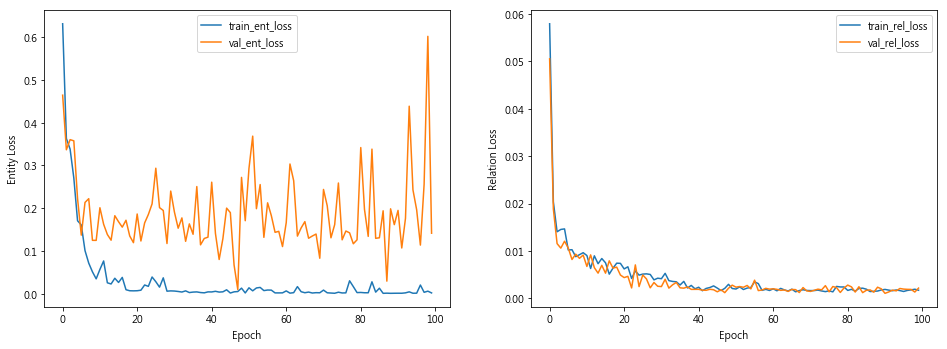

In [12]:
%matplotlib inline

import matplotlib.pyplot as plt


plt.figure(figsize=(16, 12))
plt.subplot(2,2,1)
plt.plot(train_entloss_l, label='train_ent_loss')
plt.plot(val_entloss_l, label='val_ent_loss')
plt.xlabel("Epoch")
plt.ylabel("Entity Loss") 
plt.legend()

plt.subplot(2,2,2)
plt.plot(train_relloss_l, label='train_rel_loss')
plt.plot(val_relloss_l, label='val_rel_loss')
plt.xlabel("Epoch")
plt.ylabel("Relation Loss") 
plt.legend()
plt.show()

In [13]:
import random
def random_choose(input_var):
    r_choose = []
    for i in range(BATCH_SIZE):
        r_choose.append(random.randint(0,len(input_var)))
    return r_choose
        
def ent_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,ent_size).argmax(2)
    return output

def rel_argmax(output, batchsize):
    output = output.view(batchsize,MAX_LEN,MAX_LEN,rel_size).argmax(3)
    return output

In [14]:
# Check predictions after training
with torch.no_grad():
    r_choose = random_choose(input_var)
    model.eval()
    ent_output, rel_output = model(input_var[r_choose].cuda() if USE_CUDA else input_var, batch_ent.cuda() \
                                       if USE_CUDA else batch_ent, isTrain=True)
    
    batchsize = input_var[r_choose].size(0)
    
    ent_loss = criterion_tag(ent_output.cpu(), ent_var[r_choose].view(BATCH_SIZE*MAX_LEN))
    ent_output = ent_argmax(ent_output, batchsize)
    
    rel_loss = criterion_rel(rel_output.cpu(), rel_var[r_choose].view(BATCH_SIZE*MAX_LEN*MAX_LEN))
    
    print()
    print('predict :', index2tag(ent_output[0], ix_to_ent_tag))
    print('true :', index2tag(ent_var[r_choose[0]], ix_to_ent_tag))
    
    print()
    print("Entity loss : %.4f" % ent_loss)
    print("Relation loss : %.4f" % rel_loss)


predict : ['O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
true : ['O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']

Entity loss : 0.0021
Relation loss : 0.0015


In [15]:
from sklearn.metrics import precision_recall_fscore_support
import warnings
warnings.filterwarnings('always') 

def evaluate_data(data_loader, raw_input, isTrain=False, silent=False):
    tps, fps, tns, fns = 0, 0, 0, 0
    y_ent_true_all, y_ent_pred_all = [], []
    y_rel_true_all, y_rel_pred_all = [], []
    print_every_batch = 5

    with torch.no_grad():
        for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(data_loader):
            model.eval()
            ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                           if USE_CUDA else batch_ent, isTrain)

            batchsize = batch_x.size(0)

            ent_loss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN))
            ent_output = ent_argmax(ent_output, batchsize)

            rel_loss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))
            rel_output = rel_argmax(rel_output, batchsize)

            
            if not silent:
                print()    
                print("Entity loss : %.4f" % ent_loss)
                print("Relation loss : %.4f" % rel_loss)
                print()
                print('===========================================')
                
#             elif step%print_every_batch==0:
#                 print()    
#                 print("Entity loss : %.4f" % ent_loss)
#                 print("Relation loss : %.4f" % rel_loss)
#                 print()
#                 print('===========================================')
            else:
                pass

            tp, fp, tn, fn, y_true_ent, y_pred_ent, y_true_rel, y_pred_rel = \
            batch_decode(ent_output, rel_output, batch_index, raw_input, batch_ent, batch_rel, silent)
            
            
            
            

            y_ent_true_all.extend(y_true_ent)
            y_ent_pred_all.extend(y_pred_ent)

            y_rel_true_all.extend(y_true_rel)
            y_rel_pred_all.extend(y_pred_rel)
            
            tps += tp
            fps += fp
            tns += tn
            fns += fn
        
        
        print()
        print("Entity detection score")
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        p_r_f1 = precision_recall_fscore_support(y_ent_true_all, y_ent_pred_all, average='micro', 
                                                  labels=range(len(schema['entity'])))
        print('%.3f \t\t %.3f \t\t %.3f \t' % (p_r_f1[0], p_r_f1[1], p_r_f1[2]))
        

        print()
        print("Relation detection score")
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        p_r_f1 = precision_recall_fscore_support(y_rel_true_all, y_rel_pred_all, average='micro', 
                                              labels=range(len(schema['relation'])))
        print('%.3f \t\t %.3f \t\t %.3f \t' % (p_r_f1[0], p_r_f1[1], p_r_f1[2]))
        

        print()
        print("ReferenceEntity+Relation score")
        print("%s \t %s \t %s \t    %s %s %s %s" % ('precision ', 'recall ', 'fbeta_score ', 'tp', 'fp', 'tn', 'fn'))
        p_r_f1 = p_r_fscore(tps, fps, tns, fns)
        print('%.3f \t\t %.3f \t\t %.3f \t\t    %d %d %d %d' % (p_r_f1[0], p_r_f1[1], p_r_f1[2], tps, fps, tns, fns))

            
            
def batch_decode(ent_output, rel_output, batch_index, word_lists, true_ent, true_rel, silent):
    
    eval_ent_list_true_l, eval_rel_list_true_l = [], []
    eval_ent_list_pred_l, eval_rel_list_pred_l = [], []
    
    for e,r,i,te,tr in zip(ent_output, rel_output, batch_index, true_ent, true_rel):
        
        # 算句子長度
        len_of_list = len(word_lists[i])
        word_list = word_lists[i]
        true_ent = index2tag(te, ix_to_ent_tag)[:len_of_list]
        pridict_ent = index2tag(e, ix_to_ent_tag)[:len_of_list]     
        
        # 單句decode關係
        true_r_list, appear_error = decode_rel(te, tr)   # true
        pre_r_list, appear_error = decode_rel(e, r)      # predict
        
        true_r_list = [list(set(i)) if type(i) is list else i for i in true_r_list]
        pre_r_list = [list(set(i)) if type(i) is list else i for i in pre_r_list]
        
        # 出現error，跳過這句
        if appear_error:
            continue
        
        true_r_list = true_r_list[:len_of_list]
        pre_r_list = pre_r_list[:len_of_list]
        
        
        # 評分用
        eval_ent_list_true, err_count = decode_ent(true_ent, schema)
        eval_rel_list_true = decode_rel_to_eval(true_r_list, schema, eval_ent_list_true)
        
        eval_ent_list_pred, err_count = decode_ent(pridict_ent, schema)
        eval_rel_list_pred = decode_rel_to_eval(pre_r_list, schema, eval_ent_list_pred)
        
        if not silent:
            print(word_list)
            print(true_ent)
            print(true_r_list)
            print()
            print('Predict output')
            print(pridict_ent)
            print(pre_r_list)
            print()
            print('True')
            print(eval_ent_list_true)
            print(eval_rel_list_true)
            print('predict')
            print(eval_ent_list_pred)
            print(eval_rel_list_pred)
            print("=====================================")
        
        eval_ent_list_true_l.append(eval_ent_list_true)
        eval_rel_list_true_l.append(eval_rel_list_true)
        eval_ent_list_pred_l.append(eval_ent_list_pred)
        eval_rel_list_pred_l.append(eval_rel_list_pred)
    
    
    e_score, y_true_ent, y_pred_ent = get_scores(eval_ent_list_true_l, eval_ent_list_pred_l, \
                                                 range(len(schema['entity'])),output_y=True)
    r_score, y_true_rel, y_pred_rel = get_scores(eval_rel_list_true_l, eval_rel_list_pred_l, \
                                                 range(len(schema['relation'])),output_y=True)
    
    tp, fp, tn, fn = relation_error_analysis(eval_rel_list_true_l, eval_rel_list_pred_l)
    
    if not silent:
        print('Batch entity score')
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        print(e_score)
        print()
        print('Batch relation score')
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        print(r_score)
        print()
        print('p_r_fscore')
        print("%s \t %s \t %s \t" % ('precision ', 'recall ', 'fbeta_score '))
        print(p_r_fscore(tp, fp, tn, fn), tp, fp, tn, fn)
        print('===========================================')
    
    return tp, fp, tn, fn, y_true_ent, y_pred_ent, y_true_rel, y_pred_rel
        
        



def decode_ent(pred_ent, schema):
    '''
    Aggregate entities from predicted tags
    Input:
    pred_ent=a list of entity tags in a sentence
    schema=the dictionary defining entities and relations
    Output: 
    ent_list=[(ent_start, ent_end, ent_type=eid_in_schema)]
    err_count=the number of bad tags
    '''
    ent_list = []
    ent_start = 0
    ent_end = 0
    state = {
        'ENT_SPAN': 0,
        'NO_ENT': 1
    }
    err_count = 0
    ent_type = ''
    sid = state['NO_ENT']
    for idx, e_tag in enumerate(pred_ent):
        bio = e_tag[0]
        type_tag = e_tag.split('-')[-1]
        if sid == state['NO_ENT']:
            if bio == 'B':
                ent_start = idx
                ent_type = get_eid_from_tag(type_tag, schema)
                sid = state['ENT_SPAN']
            elif bio == 'I':
                err_count += 1
        elif sid == state['ENT_SPAN']:
            if bio != 'I':
                ent_end = idx - 1
                ent_list.append((ent_start, ent_end, ent_type))
                if bio == 'B':
                    ent_start = idx
                    ent_type = get_eid_from_tag(type_tag, schema)
                else:
                    sid = state['NO_ENT']
            elif ent_type != get_eid_from_tag(type_tag, schema):
                ent_end = idx - 1
                ent_list.append((ent_start, ent_end, ent_type))
                err_count += 1
                sid = state['NO_ENT']
    if sid == state['ENT_SPAN']:
        ent_end = len(pred_ent) - 1
        ent_list.append((ent_start, ent_end, ent_type))
    return ent_list, err_count

def get_eid_from_tag(tag, schema):
    '''
    Assume schema is a dictionary in schema.txt
    return eid or -1 if no match is found
    '''
    for content in schema['entity'].values():
        if content['tag'] == tag:
            return content['eid']
    return -1



def decode_rel_to_eval(r_list, schema, ent_list):
    
    max_pair = 0
    for r in r_list:
        if type(r) is list:
            for single_r in r:
                if int(single_r[-3])>max_pair:
                    max_pair = int(single_r[-3])
    

    pair_idx = {}
    for pair in range(max_pair+1):
        for i, r in enumerate(r_list):
            if type(r) is list:
                for single_r in r:
                    if int(single_r[-3])==pair:
                        if pair not in pair_idx:
                            pair_idx[pair] = [i]
                        else:
                            pair_idx[pair].append(i)
    
    
#     # 算兩兩不同tag的數目
#     e_type_dict = {}
#     for e_pair in ent_list:
#         if e_pair[-1] not in e_type_dict:
#             e_type_dict[e_pair[-1]] = 1
#         else:
#             e_type_dict[e_pair[-1]] += 1
    
#     total_pair = 0
#     e_type_l = list(e_type_dict.values())
#     for i, ent_type_num_1 in enumerate(e_type_l):
#         for j, ent_type_num_2 in enumerate(e_type_l[i+1:]):
#             pair_num = ent_type_num_1*ent_type_num_2
#             total_pair += pair_num

    pair_list = []
    for i, e_pair_1 in enumerate(ent_list):
        for j, e_pair_2 in enumerate(ent_list[i+1:]):
            if e_pair_1[-1]!=e_pair_2[-1]:
                pair_list.append([e_pair_1, e_pair_2])
                
                
    
    
    eval_rel_list = []
    for pair in pair_idx:
        rel_loc = pair_idx[pair]
        for e_pairs in pair_list:
            check_pair = True
            first_start = e_pairs[0][0]
            first_end = e_pairs[0][1]
            sec_start = e_pairs[1][0]
            sec_end = e_pairs[1][1]
            
            first_l = list(range(first_start, first_end+1))
            sec_l = list(range(sec_start, sec_end+1))
            combine_l = first_l+sec_l

            
            check_in_entity = []
            for x in combine_l:
                if x in rel_loc:
                    check_in_entity.append(True)
                else:
                    check_in_entity.append(False)
                    check_pair = False
                    break             

            if all(check_in_entity)==True:
                for r in r_list[first_start]:
                    r_info = r.split('-')
                    
                    if int(r_info[1])==pair:
                        r_tag = get_rid_from_tag(r_info[0], schema)
                        e_pairs_copy = e_pairs
                        e_pairs_copy.append(r_tag)
                        eval_rel_list.append(tuple(e_pairs_copy))
    
    return eval_rel_list
    
        
def get_rid_from_tag(tag, schema):   
    for content in schema['relation'].values():
        if content['tag'] == tag:
            return content['rid']




def create_rel_info(ent_output):
    r_list = []     # 存放完整關係
    r_dict = {}     # 記錄關係資訊
    appear_error = False

    pred_ent = index2tag(ent_output, ix_to_ent_tag)
    

    e_loc = 0       # 當前遇到的entity的位置
    for loc, e in enumerate(pred_ent):
        if e[0]=='B':
            e_loc = loc
            r_dict[loc] = {
                '_2ndtag':e[2:],
                'end':loc,
            }
            r_list.append([])
                   
        elif e[0]=='I':
            # 錯誤來自於，entity預測錯誤，沒有預測到B tag，直接跳到I tag
            # 所以沒有紀錄e_loc
            try: 
                r_dict[e_loc]['end'] = loc
            except KeyError:
                appear_error = True
                break
            
            r_list.append([])
            
        else:
            r_list.append("")
              
    return r_list, r_dict, appear_error
        
        
def decode_rel(ent_output, rel_output):

    r_list, r_dict, appear_error = create_rel_info(ent_output) 
    
    IsB = False           # 是否遇到B tag的lock
    IsNext = False        # 是否為B tag後面的tag 的lock
    num_reocrd = -1       # 紀錄pair數
    now_loc = 0
    pre_rel_end_loc = 0
    now_rel_end_loc = 0
    
    rel_keyerror = False
    
    for now in range(len(rel_output)):
        for loc, rel in enumerate(rel_output[now][:now+1]):
            rel = rel.cpu().numpy()
            
#             print(rel, IsB, IsNext)
            
            # 有關係存在，且為B tag 
            if rel!=rel_tag_to_ix[REL_NONE] and IsB==False and IsNext==False:

                IsB = True
                IsNext = True
                tag = ix_to_rel_tag[int(rel)]
                num_reocrd+=1
                now_loc = loc
                
                # 錯誤來自於，now_loc找不到，也就是說，rel預測出來是有關係存在
                # 但預測是'O'
                # 而在entity中卻沒有預測出來，所以r_dict中沒有紀錄
                try:
                    pre_rel_end_loc = r_dict[now_loc]['end']

                except KeyError:
                    rel_keyerror = True
                    break
                    
                
                try:
                    now_rel_end_loc = r_dict[now]['end']
                    
                except KeyError:
                    rel_keyerror = True
                    break
            
             
                second_tag = r_dict[now_loc]['_2ndtag']
                preAorB = check_rel_loc(second_tag, schema)
                nowAorB = 'B' if preAorB=='A' else 'A'
                
                pre_complete_rel = tag+"-"+str(num_reocrd)+"-"+preAorB
                now_complete_rel = tag+"-"+str(num_reocrd)+"-"+nowAorB
                
                # 將以前的token填上關係
                for token in range(now_loc, pre_rel_end_loc+1):
                    
                    # 出現以下error
                    '''AttributeError: 'str' object has no attribute 'append'''
                    # 為 r_list 前處理中沒有給予可能有關係的位置空的list
                    try:
                        r_list[token].append(pre_complete_rel)
                    except AttributeError:
                        r_list[token] = []
                        r_list[token].append(pre_complete_rel)

             
                # 當前token填上關係
                r_list[now].append(now_complete_rel)
                

            
            # 關係前位中B tag後面的tag
            elif rel!=rel_tag_to_ix[REL_NONE] and IsB:
                # 如果還在這個entity的範圍內
                if loc<=pre_rel_end_loc:
                    pass
                
                # 超出現在這個entity的範圍，改lock
                else:
                    IsB = False

            
            # B tag後面的tag的關係，依照前面的關係複製
            elif rel!=rel_tag_to_ix[REL_NONE] and IsNext:
                r_list[now] = r_list[now-1]
                
                
            else:
                if now<=now_rel_end_loc:
                    IsB = False
                else:
                    IsB = False
                    IsNext = False

        
        if rel_keyerror:
            rel_keyerror = False
            break
                
                
    return r_list, appear_error
                

# 是三元關係中的前者還是後者                  
def check_rel_loc(second_tag, schema):
    convert_tag = ''

    for ent_content in schema['entity']:
        if schema['entity'][ent_content]['tag']==second_tag:
            convert_tag = ent_content
    
    rel_types = schema['relation'].values()

    for rel_content in schema['relation'].values():
        for AorB in rel_content['arguments']:
            if rel_content['arguments'][AorB]==convert_tag:
                return AorB
            

            
def get_scores(true_lists, pred_lists, labels, output_y=False):
    y_true, y_pred = [], []
    for t_list, p_list in zip(true_lists, pred_lists):
        yt, yp = align_yt_yp(t_list, p_list, labels)
        y_true.extend(yt)
        y_pred.extend(yp)
        
    scores = precision_recall_fscore_support(y_true, y_pred, average='micro', labels=labels)
    return scores, y_true, y_pred if output_y else scores

def align_yt_yp(truths, predictions, labels):
    '''
    Input:
        truths/predictions: list of true and predicted tuples, 
        with the leading entries as the structure and the last entry as the class,
        e.g., [(e1, e2, rel), ...]
        labels: sequence of valid class
    Output:
        yt: list of true class given a structure
        yp: list of predicted class given a structure
    '''
    yt, yp = [], []
    _ID_NONE = len(labels)
    true_dict = { t[:-1]: t[-1] for t in truths }
    for p in predictions:
        yt.append(true_dict.pop(p[:-1], _ID_NONE))
        yp.append(p[-1])
    for target in true_dict.values():
        yt.append(target)
        yp.append(_ID_NONE)
    return yt, yp



def is_neg_triple(t):
    return np.imag(t[-1]) > 0

def negate_triple(t):
    # Mark negative triples with imaginary relation id
    return (t[0], t[1], np.real(t[-1]).item() + 1j)

def posit_triple(t):
    return (t[0], t[1], np.real(t[-1]).item())

def has_edge(base_ptrs, rel, e):
    '''
    Assume a relation exist between an entity pair, 
    if all the tokens in the base entity point to those in entity e.
    '''
    tok_has_ptr_to_e = [tok_ptrs[rel].ge(e[0]).dot(tok_ptrs[rel].le(e[1])).item() > 0 
                        for tok_ptrs in base_ptrs]
    return len(tok_has_ptr_to_e) > 0 and all(tok_has_ptr_to_e)


def relation_error_analysis(true_rel_lists, rel_lists):
    tp, fp, tn, fn = 0, 0, 0, 0
    for i, r_list in enumerate(rel_lists):
        true_pos = len([t for t in r_list if t in true_rel_lists[i]])
        all_true = len([t for t in true_rel_lists[i] if not is_neg_triple(t)])
        all_pos = len(r_list)
        tp += true_pos
        fn += all_true - true_pos
        fp += all_pos - true_pos
        tn += len([t for t in true_rel_lists[i] if is_neg_triple(t) and posit_triple(t) not in r_list])
    return tp, fp, tn, fn

def p_r_fscore(tp, fp, tn, fn, beta=1, eps=1e-8):
    p = tp / (tp + fp + eps)
    r = tp / (tp + fn + eps)
    f_beta = (1 + beta**2) * ((p * r) / (((beta**2) * p) + r + eps))
    return p, r, f_beta

In [16]:
evaluate_data(dev_loader, raw_input_dev, isTrain=True)


Entity loss : 0.2378
Relation loss : 0.0023

['這', '款', '面', '膜', '它', '強', '調', '乾', '肌', '及', '肌', '膚', '鬆', '弛', '.', '.', '.', '等', ',', '但', '我', '發', '現', '緊', '緻', '的', '部', '份', '不', '是', '那', '麼', '明', '顯', ',', '但', '保', '濕', '部', '分', '我', '倒', '是', '很']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', '

['在', '這', '一', '下', '冷', '一', '下', '又', '熱', '的', '氣', '候', ',', '對', '於', '乾', '性', '肌', '膚', '的', '我', '來', '說', ',', '真', '是', '相', '當', '需', '要', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

True
[(15, 18, 1)]
[]
predict
[(15, 18, 1), (30, 31, 0)]
[((15, 18, 1), (30, 31, 0), 0)]
['像', '我', '本', '身', '有',

['第', '三', '種', '方', '式', '是', '每', '週', '1', '-', '2', '次', '，', '夜', '間', '所', '有', '保', '養', '程', '序', '後', '，', '以', '厚', '敷', '來', '加', '強', '肌', '膚', '乾', '燥', '部', '位', '的', '照', '顧']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], [], [], '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'

['我', '的', '皮', '膚', '是', '乾', '性', '肌', ',', '雖', '然', '在', '夏', '天', '不', '會', '乾', '到', '緊', '繃', ',', '但', '每', '天', '還', '是', '要', '加', '強', '保', '濕']
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', [], [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], []]

Predict output
['O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

True
[(5, 7, 1), (29, 30, 0)]
[]
predict
[(5, 7, 1), (29, 30, 0)]
[((5, 7, 1), (29, 30, 0), 0)]
['使', '用', '完', '後', '肌', '膚', '乾', '淨', '舒', '服', ','

In [17]:
test_data = root+'facial_r2.test'
input_test, ent_test, rel_test, raw_index_test, raw_input_test = dev_preprocess(test_data)
test_loader = dataload(input_test, ent_test, rel_test, raw_index_test)

In [18]:
evaluate_data(test_loader, raw_input_test, isTrain=True, silent=True)


Entity detection score
precision  	 recall  	 fbeta_score  	
0.758 		 0.946 		 0.842 	

Relation detection score
precision  	 recall  	 fbeta_score  	
0.431 		 0.727 		 0.541 	

ReferenceEntity+Relation score
precision  	 recall  	 fbeta_score  	    tp fp tn fn
0.431 		 0.727 		 0.541 		    93 123 0 35


In [19]:
def continue_train():
    
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    criterion_tag = nn.NLLLoss(ignore_index=ent_tag_to_ix[PAD_TAG])
    criterion_rel = nn.NLLLoss()
    
    n_iters = 1
    print_every = 12

    train_entloss_l = []
    val_entloss_l = []
    train_relloss_l = []
    val_relloss_l = []

    loss = 0
    
    for epoch in tqdm(range(n_iters)):  
        for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(loader):
            model.train()
            optimizer.zero_grad()
            ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                           if USE_CUDA else batch_ent, isTrain=True)

            batchsize = batch_x.size(0)

            batch_ent = batch_ent.view(batchsize*MAX_LEN)
            batch_rel = batch_rel.view(batchsize*MAX_LEN*MAX_LEN)

            entloss = criterion_tag(ent_output, batch_ent.cuda() if USE_CUDA else batch_ent)
            relloss = criterion_rel(rel_output, batch_rel.cuda() if USE_CUDA else batch_rel)
            loss = entloss+relloss

            loss.backward()
            optimizer.step()


        train_entloss_l.append(entloss.cpu())
        train_relloss_l.append(relloss.cpu())
        #    print('%.4f| epoch: %d| step: %d| %s' % (loss, epoch, step, timeSince(start)))

        for step, (batch_x, batch_ent, batch_rel, batch_index) in enumerate(dev_loader):
            model.eval()
            ent_output, rel_output = model(batch_x.cuda() if USE_CUDA else batch_x, batch_ent.cuda() \
                                           if USE_CUDA else batch_ent, isTrain=True)

            batchsize = batch_x.size(0)

            val_entloss = criterion_tag(ent_output.cpu(), batch_ent.view(batchsize*MAX_LEN)) 
            val_relloss = criterion_rel(rel_output.cpu(), batch_rel.view(batchsize*MAX_LEN*MAX_LEN))

        val_entloss_l.append(val_entloss.cpu())
        val_relloss_l.append(val_relloss.cpu())

        
        
        evaluate_data(loader, raw_input, isTrain=True, silent=True)
        
        print()
        print("epoch: %d | ent loss %.4f | rel loss %.4f | total loss %.4f" \
              % (epoch+1, entloss, relloss, loss))
        print("      %s  | val ent loss %.4f | val rel loss %.4f"
              % (" "*len(str(epoch+1)), val_entloss, val_relloss))
        

In [20]:
# continue_train()

In [21]:
# evaluate_data(dev_loader, raw_input_dev, isTrain=True)

In [22]:
# evaluate_data(test_loader, raw_input_test, isTrain=True, silent=True)

In [23]:
evaluate_data(dev_loader, raw_input_dev, isTrain=False)


Entity loss : 0.1460
Relation loss : 0.0018

['使', '用', '了', '幾', '次', '，', '效', '果', '都', '不', '太', '令', '人', '滿', '意', '，', '也', '許', '是', '這', '款', '面', '膜', '主', '要', '強', '調', '的', '是', '緊', '緻', '功', '能', '，', '我', '的', '超', '乾', '肌', '得', '先', '把', '缺', '水', '問', '題', '解', '決', '了', '才', '能', '看', '出', '效', '果', '吧', '∼']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', '

['若', '乾', '性', '肌', '膚', '使', '用', '會', '保', '濕', '度', '不', '足']
['O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O']
['', [], [], [], [], '', '', '', [], [], [], '', '']

Predict output
['O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'I-FUNC', 'O', 'O']
['', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '']

True
[(1, 4, 1), (8, 10, 0)]
[]
predict
[(1, 4, 1), (8, 10, 0)]
[((1, 4, 1), (8, 10, 0), 0)]
['當', '天', '擦', '就', '馬', '上', '覺', '得', '皮', '膚', '乾', '燥', '感', '得', '到', '舒', '緩']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC']
['', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A']]

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT',

['不', '過', '乾', '性', '肌', '膚', '敷', '完', '後', '可', '能', '要', '馬', '上', '擦', '點', '保', '濕', '的', '保', '養', '品', '不', '然', '皮', '膚', '會', '緊', '緊', '繃', '繃', '的', '喔']
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', [], [], [], [], '', '', '', '', '', '', '', '', '', '', [], [], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
['O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', [], [], '', '', '', '', '', '', '', '', '', '', '', '']

True
[(2, 5, 1), (16, 17, 0)]
[]
predict
[(2, 5, 1), (16, 17, 0), (19, 

['像', '我', '本', '身', '有', '輕', '微', '過', '敏', '膚', '質', '的', '情', '況', '，', '只', '要', '在', '悶', '熱', '的', '環', '境', '中', '肌', '膚', '就', '容', '易', '產', '生', '泛', '紅', '的', '情', '形', '，', '這', '幾', '天', '都', '靠', '蠟', '菊', '純', '露', '面', '膜', '來', '舒', '緩', '肌', '膚']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O']
['', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '']

Predict output
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

['夏', '日', '將', '到', '了', '，', '保', '濕', '不', '是', '只', '有', '在', '冬', '天', '，', '夏', '天', '會', '常', '常', '待', '在', '冷', '氣', '房', '，', '所', '以', '保', '濕', '還', '是', '很', '重', '要', '，', '而', '這', '面', '膜', '對', '於', '乾', '燥', '的', '肌', '膚', '急', '救', '補', '水', '效', '果', '還', '挺', '讓', '人', '滿', '意', '的']
['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-FUNC', 'I-FUNC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'I-STAT', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
['', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-A'], ['ApplyTo-0-A'], '', '', '', '', '', '', '', '', '', '', '', '', ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], ['ApplyTo-0-B'], '', '', '', '', '', '', '', '', '', '', '', '', '']

Predict output
[

In [24]:
evaluate_data(test_loader, raw_input_test, isTrain=False, silent=True)


Entity detection score
precision  	 recall  	 fbeta_score  	
0.762 		 0.950 		 0.846 	

Relation detection score
precision  	 recall  	 fbeta_score  	
0.623 		 0.734 		 0.674 	

ReferenceEntity+Relation score
precision  	 recall  	 fbeta_score  	    tp fp tn fn
0.623 		 0.734 		 0.674 		    94 57 0 34


In [25]:
# input_var, ent_var, rel_var, raw_input

In [26]:
len(input_var)

254